In [1]:
%cd ../..

f:\DR\Stock-Market-Prediction\src


In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from pandas.tseries.offsets import DateOffset

from mplfinance.original_flavor import candlestick_ohlc
from cnn_normalize import prepare_data, normalize_data, generateImages, prepare_sequences, split_train_and_test_data, get_cnn_data
from utils.chart import config_chart
from constants import SP500_TICKER

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import Dataset
import os


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

tf.keras.backend.clear_session()

---

## For **prepare_data** function

In [ ]:
data = prepare_data(SP500_TICKER)


# Show data
print(data.shape)
print(data.dtypes)
# Save the plot as an image with 50x50 pixels

# Show the plot
# plt.show()
# plt.show()

plt = config_chart('Original Data')
plt.plot(data.Close)
plt.legend(['Close'])

plt = config_chart('Daily Change')
plt.plot(data.Change)
plt.legend(['Change'])


test = data['Close'] - data['Low']
tets2 = data['High'] - data['Close']

plt = config_chart('Model Data Price')
plt.plot(test [0:100])
plt.plot(tets2[0:100])
plt.plot(data.Direction[0:100])

---

## For **generateImages** function

In [ ]:


generateImages(data)

---

## For **getImages** function

Found 990 images belonging to 5 classes.
['bearish_reverse', 'bearish_trend', 'bullish_reverse', 'bullish_trend', 'neutral']
['models/cnn_v3/data/bearish_reverse', 'models/cnn_v3/data/bearish_trend', 'models/cnn_v3/data/bullish_reverse', 'models/cnn_v3/data/bullish_trend', 'models/cnn_v3/data/neutral']
990
990
Epoch 1/10
247/247 [==============================] - 30s 118ms/step - loss: 1.9753
Epoch 2/10
247/247 [==============================] - 29s 119ms/step - loss: 1.5269
Epoch 3/10
247/247 [==============================] - 29s 119ms/step - loss: 1.4889
Epoch 4/10
247/247 [==============================] - 29s 117ms/step - loss: 1.4634
Epoch 5/10
247/247 [==============================] - 29s 117ms/step - loss: 1.4470
Epoch 6/10
247/247 [==============================] - 29s 116ms/step - loss: 1.4353
Epoch 7/10
247/247 [==============================] - 29s 116ms/step - loss: 1.4309
Epoch 8/10
247/247 [==============================] - 28s 115ms/step - loss: 1.4295
Epoch 9/10
247/2

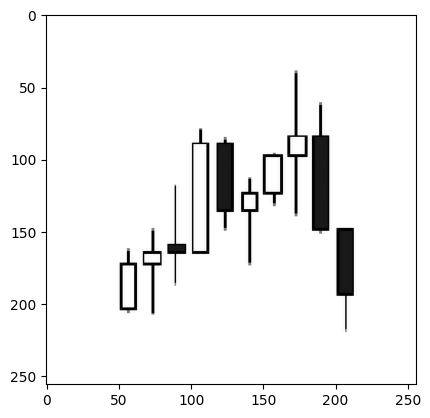

In [54]:
BASE_DIR = "models/cnn_v3/data/"

generator = ImageDataGenerator()

images = generator.flow_from_directory(BASE_DIR)

img = images.__next__()[0]
img.shape

plt.imshow(img[4] / 255.0)

Dataset.from_tensor_slices([1,2,3])

classes = os.listdir(BASE_DIR)
folders = [BASE_DIR + class_name for class_name in classes]

print(classes)
print(folders)

all_files = []
all_classes = []

for folder_name, class_name in zip(folders, classes):
    files = os.listdir(folder_name)
    all_files.extend([os.path.join(folder_name, file) for file in files])
    all_classes.extend([class_name] * len(files))

print(len(all_files))
print(len(all_classes))

class_mapping = {class_name: class_id for (class_id, class_name) in list(enumerate(classes))}

all_class_ids = [class_mapping[c] for c in all_classes]

def read_images(file_name, class_name):
    image_file = tf.io.read_file(file_name)
    image = tf.image.decode_png(image_file)
    image_scaled = tf.cast(image, float) / 255.0
    image_resized = tf.image.resize(image_scaled, (256, 256))
    return (image_resized, class_name)

dataset = Dataset.from_tensor_slices((all_files, all_class_ids)).shuffle(len(all_files)).map(read_images).batch(4).repeat()


# for el in dataset.take(1):
#     print(el[0].numpy(), el[1].numpy())
    
model = Sequential([
        Input((256, 256, 4)),
        Conv1D(filters=32, kernel_size=(1,), activation='relu'),
        Conv1D(filters=16, kernel_size=(1,), activation='relu'),
        Conv1D(filters=8, kernel_size=(1,), activation='relu'),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dense(units=5, activation='softmax')
    ])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model.fit(dataset, epochs=10, steps_per_epoch=len(all_files) // 4)



In [57]:

# prediction_data = dataset[0:10]
print(dataset)
# prediction = model.predict(dataset)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


----

## For **prepare_sequences** function

In [ ]:
indicators, indicators_dates, target, target_dates = prepare_sequences(data)

# # Show data
print(indicators.shape)
print(indicators_dates.shape)
print(indicators[0])
print(indicators_dates[0])

print(target.shape)
print(target_dates.shape)
print(target)
print(target_dates[0])

plt = config_chart('Model Data Price')
plt.plot(target_dates[0:500], target[0:500])
plt.legend(['Target'])


---

## For **split_train_and_test_data** function

In [ ]:
train, test, predict = split_train_and_test_data(indicators, target, indicators_dates, target_dates)


# Show data:
print(train["x"].shape)
print(train["y"].shape)

print(test["x"].shape)
print(test["y"].shape)

print(predict["x"].shape)
print(predict["y"].shape)

plt = config_chart('Model Data Price')
plt.plot(train['x_dates'], train['x'][:, 0])
plt.plot(test['x_dates'], test['x'][:, 0])
plt.plot(predict['x_dates'], predict['x'][:, 0])
plt.legend(['Train', 'Test', 'Predict'])

plt = config_chart('Model Data Change')
plt.plot(train['x_dates'], train['x'][:, 2])
plt.plot(test['x_dates'], test['x'][:, 2])
plt.plot(predict['x_dates'], predict['x'][:, 2])
plt.legend(['Train', 'Test', 'Predict'])

---

## For **get_lstm_data** function

In [ ]:
train, test, predict = get_cnn_data(SP500_TICKER)

In [ ]:
print(train["x"].shape) 
print(train["x"])

print(train["y"].shape)
print(train["y"])


In [ ]:
print(test["x"].shape)
print(test["x"])

print(test["y"].shape)
print(test["y"])

In [ ]:
print(predict["x"].shape) 
print(predict["x"])

print(predict["y"].shape)
print(predict["y"])

In [ ]:
num_columns = predict["x"].shape[1]  # Get the number of columns

index = 20

plt = config_chart('Model Data')
plt.plot(predict['x_dates'][0:index], predict["x"][:, 0][0:index])
plt.plot(predict['x_dates'][0:index], predict["x"][:, 1][0:index])
plt.plot(predict['x_dates'][0:index], predict["x"][:, 2][0:index])
plt.plot(predict['x_dates'][0:index], predict["x"][:, 3][0:index])
# plt.title(f'Column {i+1}')
plt.xlabel('Index')
plt.ylabel('Value')

plt.grid(True)  # Add grid
plt.tight_layout()
plt.savefig('stock_price_50x50.png', dpi=100)  # Save as PNG image with 100 DPI
plt.close()

plt.grid(True)
plt.show()


In [ ]:

# Create subplots
# fig, ax = plt.subplots()

predict_dataframe = pd.to_datetime(predict["x"])
# Plot candlestick chart
mpf.plot(predict_dataframe, type='candle', style='charles', volume=True)

# Show the plot
plt.show()